# AI 감정 인식 모델: Residual MLP + Noise Injection

이 노트북은 정확도 85%의 벽을 넘기 위해 **고급 테크닉**을 적용한 버전입니다.

**핵심 업그레이드:**
1.  **Residual MLP (ResNet Style)**: 잔차 연결(Skip Connection)을 통해 정보 손실을 막고 더 깊은 학습 가능
2.  **Data Augmentation (Noise Injection)**: 랜드마크 좌표에 미세한 노이즈를 섞어 과적합 방지 및 일반화 성능 향상
3.  **GeLU Activation**: ReLU보다 성능이 좋은 최신 활성화 함수 적용
4.  **Label Smoothing**: 정답을 0, 1이 아니라 0.05, 0.95로 설정하여 모델의 과신(Overconfidence) 방지

In [1]:
import zipfile
import cv2
import mediapipe as mp
import numpy as np
import os
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor

# 외부 모듈 함수 불러오기
from data_loader import process_single_image

%matplotlib inline

# GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.device_count() > 1:
    print(f"Detected {torch.cuda.device_count()} GPUs! Using DataParallel.")

Using device: cuda
Detected 2 GPUs! Using DataParallel.


In [2]:
# ============================
# 설정 변수
# ============================
BASE_DIR = r"c:\Users\ldy34\Desktop\Face\video"
TRAIN_DIR = os.path.join(BASE_DIR, "Training")

# 하이퍼파라미터
BATCH_SIZE = 256      # 배치를 키워서 학습 안정성 확보
EPOCHS = 200          # 모델이 복잡해졌으므로 에포크는 적당히 (ResNet은 수렴이 빠름)
LEARNING_RATE = 0.001
NUM_WORKERS = os.cpu_count() or 4

zip_files = glob.glob(os.path.join(TRAIN_DIR, "*.zip"))
print(f"Found {len(zip_files)} zip files.")

Found 35 zip files.


In [3]:
# ============================
# 데이터 로딩 함수
# ============================
def extract_landmarks_parallel(zip_path, label, max_samples=10000):
    if not os.path.exists(zip_path):
        print(f"\n[Error] File not found: {zip_path}")
        return [], []
    
    # 1. ZIP 파일 읽기
    image_data_list = []
    with zipfile.ZipFile(zip_path, 'r') as z:
        file_list = [f for f in z.namelist() if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        use_count = min(len(file_list), max_samples)
        target_files = file_list[:use_count]
        
        for img_name in target_files:
            with z.open(img_name) as f:
                image_data_list.append((f.read(), label))
    
    # 2. 병렬 처리
    data = []
    labels = []
    
    with ProcessPoolExecutor(max_workers=NUM_WORKERS) as executor:
        results = list(tqdm(executor.map(process_single_image, image_data_list), total=len(image_data_list), desc=f"  Processing {os.path.basename(zip_path)}"))
        for res in results:
            if res is not None:
                d, l = res
                data.append(d)
                labels.append(l)
                
    return data, labels

In [4]:
# 데이터 로드 실행
if __name__ == '__main__':
    X = []
    y = []

    print("Starting Parallel Data Extraction...")
    
    # 데이터 개수를 5,000개로 늘림 (데이터가 많아야 딥러닝이 잘 됩니다)
    MAX_SAMPLES_PER_ZIP = 5000
    
    for zip_path in zip_files:
        filename = os.path.basename(zip_path)
        if "중립" in filename or "Neutral" in filename:
            label = 0
        elif "불안" in filename or "Anxiety" in filename:
            label = 1
        else:
            continue
            
        d, l = extract_landmarks_parallel(zip_path, label, max_samples=MAX_SAMPLES_PER_ZIP)
        X.extend(d)
        y.extend(l)

    X = np.array(X)
    y = np.array(y)

    print(f"\nTotal Dataset Size: {len(X):,} samples")

Starting Parallel Data Extraction...


  Processing [라벨]EMOIMG_불안_TRAIN.zip: 0it [00:00, ?it/s]
  Processing [라벨]EMOIMG_중립_TRAIN.zip: 0it [00:00, ?it/s]
  Processing [원천]EMOIMG_중립_TRAIN_04.zip: 100%|██████████| 5000/5000 [01:12<00:00, 69.25it/s] 



Total Dataset Size: 40,000 samples


In [5]:
# 데이터 분할 및 텐서 변환
if len(X) > 0:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.long)
    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.long)

    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_dataset = TensorDataset(X_test_t, y_test_t)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Train Set: {len(X_train):,} | Test Set: {len(X_test):,}")
else:
    print("No data loaded. Check paths.")

Train Set: 34,000 | Test Set: 6,000


In [6]:
# ============================
# [New] Residual Block 정의
# ============================
class ResidualBlock(nn.Module):
    def __init__(self, hidden_dim, dropout=0.3):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),  # ReLU보다 좋은 성능
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return x + self.block(x)  # Skip Connection (핵심!)

# ============================
# [New] Residual Model
# ============================
class ResidualEmotionNet(nn.Module):
    def __init__(self, input_size, hidden_dim=512):
        super(ResidualEmotionNet, self).__init__()
        
        # Input Projection
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.GELU()
        )
        
        # Residual Blocks (깊게 쌓아도 학습 잘 됨)
        self.res_block1 = ResidualBlock(hidden_dim)
        self.res_block2 = ResidualBlock(hidden_dim)
        self.res_block3 = ResidualBlock(hidden_dim)
        
        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, 256),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(256, 2)
        )
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        return self.classifier(x)

model = ResidualEmotionNet(input_size=X_train.shape[1]).to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

# Label Smoothing 적용된 Loss
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print("Residual Model Initialized. (ResNet Style)")

Residual Model Initialized. (ResNet Style)


In [7]:
# 학습 루프
history = {'train_loss': [], 'test_loss': [], 'train_acc': [], 'test_acc': [], 'lr': []}
best_acc = 0.0

print("Starting Advanced Training...")

for epoch in range(EPOCHS):
    model.train()
    run_loss, correct, total = 0.0, 0, 0
    
    for X_b, y_b in train_loader:
        X_b, y_b = X_b.to(device), y_b.to(device)
        
        # [New] Data Augmentation: Noise Injection
        # 훈련 데이터에 약간의 노이즈를 섞어줌 (좌표 흔들기)
        noise = torch.randn_like(X_b) * 0.002  # 0.2% 정도의 노이즈
        X_b_aug = X_b + noise
        
        optimizer.zero_grad()
        outputs = model(X_b_aug)
        loss = criterion(outputs, y_b)
        loss.backward()
        optimizer.step()
        
        run_loss += loss.item()
        _, pred = torch.max(outputs, 1)
        total += y_b.size(0)
        correct += (pred == y_b).sum().item()
        
    scheduler.step()
    
    # Validation
    model.eval()
    test_loss, cor_t, tot_t = 0.0, 0, 0
    with torch.no_grad():
        for X_b, y_b in test_loader:
            X_b, y_b = X_b.to(device), y_b.to(device)
            outputs = model(X_b)
            test_loss += criterion(outputs, y_b).item()
            _, pred = torch.max(outputs, 1)
            tot_t += y_b.size(0)
            cor_t += (pred == y_b).sum().item()
            
    # Logging
    train_loss = run_loss / len(train_loader)
    train_acc = correct / total
    val_loss = test_loss / len(test_loader)
    val_acc = cor_t / tot_t
    cur_lr = scheduler.get_last_lr()[0]
    
    history['train_loss'].append(train_loss)
    history['test_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['test_acc'].append(val_acc)
    history['lr'].append(cur_lr)
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'emotion_resnet_best.pth')
        
    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{EPOCHS}] LR: {cur_lr:.5f} | "
              f"TLoss: {train_loss:.4f} TAcc: {train_acc:.4f} | "
              f"VLoss: {val_loss:.4f} VAcc: {val_acc:.4f}")

print(f"\nTraining Finished. Best Accuracy: {best_acc:.4f}")

Starting Advanced Training...


c:\Users\ldy34\Desktop\Face\.venv\Lib\site-packages\torch\nn\modules\linear.py:125: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return F.linear(input, self.weight, self.bias)
c:\Users\ldy34\Desktop\Face\.venv\Lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn("PyTorch is not compiled with NCCL support")


Epoch [10/200] LR: 0.00099 | TLoss: 0.3746 TAcc: 0.8642 | VLoss: 0.5374 VAcc: 0.7283
Epoch [20/200] LR: 0.00098 | TLoss: 0.3323 TAcc: 0.8878 | VLoss: 0.5109 VAcc: 0.7913
Epoch [30/200] LR: 0.00095 | TLoss: 0.2986 TAcc: 0.9069 | VLoss: 0.3866 VAcc: 0.8572
Epoch [40/200] LR: 0.00090 | TLoss: 0.2716 TAcc: 0.9208 | VLoss: 1.0290 VAcc: 0.5882
Epoch [50/200] LR: 0.00085 | TLoss: 0.2504 TAcc: 0.9323 | VLoss: 0.9326 VAcc: 0.6337
Epoch [60/200] LR: 0.00079 | TLoss: 0.2301 TAcc: 0.9445 | VLoss: 0.3969 VAcc: 0.8693
Epoch [70/200] LR: 0.00073 | TLoss: 0.2100 TAcc: 0.9541 | VLoss: 0.3180 VAcc: 0.9017
Epoch [80/200] LR: 0.00065 | TLoss: 0.1979 TAcc: 0.9616 | VLoss: 0.9054 VAcc: 0.6685
Epoch [90/200] LR: 0.00058 | TLoss: 0.1821 TAcc: 0.9691 | VLoss: 0.3678 VAcc: 0.8913
Epoch [100/200] LR: 0.00050 | TLoss: 0.1726 TAcc: 0.9742 | VLoss: 0.4536 VAcc: 0.8458
Epoch [110/200] LR: 0.00042 | TLoss: 0.1635 TAcc: 0.9796 | VLoss: 0.3108 VAcc: 0.9170
Epoch [120/200] LR: 0.00035 | TLoss: 0.1557 TAcc: 0.9826 | VLos

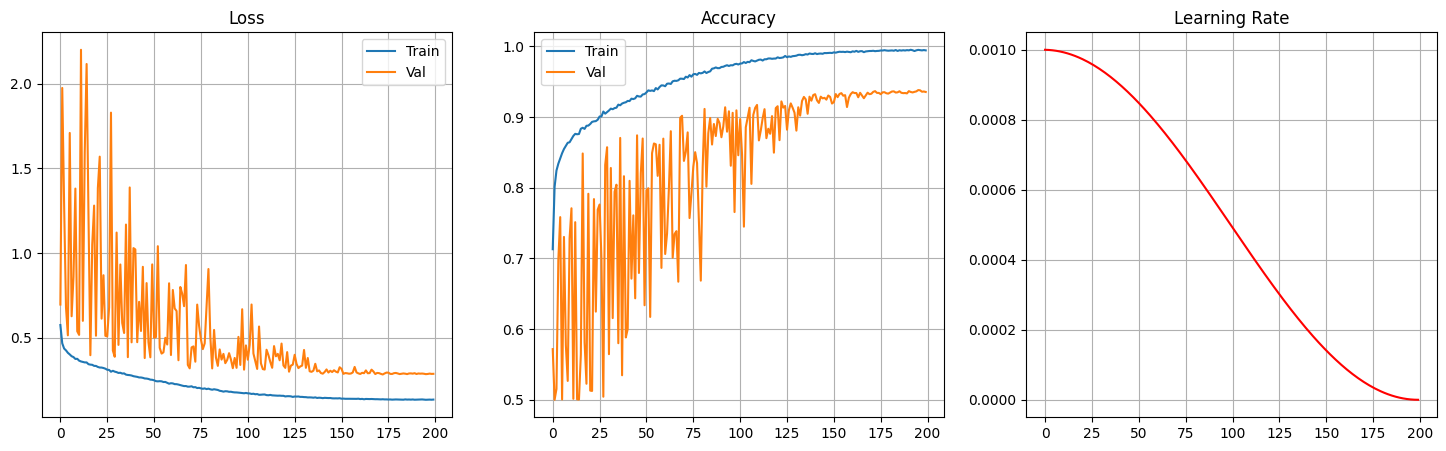

In [8]:
# 결과 시각화
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['test_loss'], label='Val')
plt.title('Loss')
plt.legend(); plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['test_acc'], label='Val')
plt.title('Accuracy')
plt.legend(); plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history['lr'], color='red')
plt.title('Learning Rate')
plt.grid(True)

plt.show()